In [122]:
import sys, platform
print("Python:", sys.version)
print("OS:", platform.platform())
try:
    import tensorflow as tf
    print("tensorflow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    print("TF-Check:", e)


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26100-SP0
tensorflow: 2.20.0 | GPUs: 0


In [125]:
import sys, os
ROOT = os.path.abspath("..")  # Projekt-Root (eine Ebene über notebooks/)
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from finance_lstm import read_prices
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [126]:
TICKER   = "AAPL"           # Beispiel: Apple
START    = "2012-01-01"
END      = "2025-09-01"
INTERVAL = "1d"
HORIZON = 1                 # Vorhersage: 1 Tag in die Zukunft

In [127]:
df = yf.download(
    TICKER, start=START, end=END, interval=INTERVAL,
    auto_adjust=True, group_by="column", threads=False, progress=False
)

In [128]:
# --- Spalten robust vereinheitlichen ---
# MultiIndex? -> Ebene mit den Feldnamen (Open/High/...) finden
if isinstance(df.columns, pd.MultiIndex):
    top  = df.columns.get_level_values(0).str.lower()
    bot  = df.columns.get_level_values(1).str.lower()
    # Falls die untere Ebene die typischen Felder enthält, nimm die:
    if {"open","high","low","close","adj close","volume"} & set(bot):
        df.columns = df.columns.get_level_values(1)
    # Falls die obere Ebene die Felder enthält (selten), nimm die:
    elif {"open","high","low","close","adj close","volume"} & set(top):
        df.columns = df.columns.get_level_values(0)
    else:
        # Fallback: Wenn die obere Ebene überall der Ticker ist (aapl...),
        # dann nimm die untere Ebene.
        if len(set(top)) == 1:
            df.columns = df.columns.get_level_values(1)
        else:
            raise RuntimeError(f"Unbekannte MultiIndex-Struktur: {list(df.columns)})")

# Spaltennamen normalisieren
df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ", ""))

# Wenn nur adjclose existiert, bau close daraus
if "close" not in df.columns and "adjclose" in df.columns:
    df["close"] = df["adjclose"]

# Index & Reihenfolge
df.index = pd.to_datetime(df.index, errors="coerce")
df = df[~df.index.isna()].sort_index()

# Pflichtspalten prüfen (BEVOR du droppst):
required = {"open","high","low","close","volume"}
missing  = required - set(df.columns)
if missing:
    print("Spalten gefunden:", list(df.columns))
    raise KeyError(f"Fehlende Pflichtspalten nach Normalisierung: {sorted(missing)}")

# Numerik + NaNs raus
for c in required.union({"adjclose"}):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=list(required), how="any")


In [129]:
# --- Quick sanity checks ---
if df.empty:
    raise ValueError("Download ergab keine Daten. Ist das Intervall/Datum ok? Rate-Limit?")
if df.index.has_duplicates:
    raise ValueError("Duplicate timestamps gefunden.")

print("Spalten final:", df.columns.tolist())
print("Zeitraum:", df.index.min().date(), "→", df.index.max().date(), "| n =", len(df))

Spalten final: ['close', 'high', 'low', 'open', 'volume']
Zeitraum: 2012-01-03 → 2025-08-29 | n = 3435


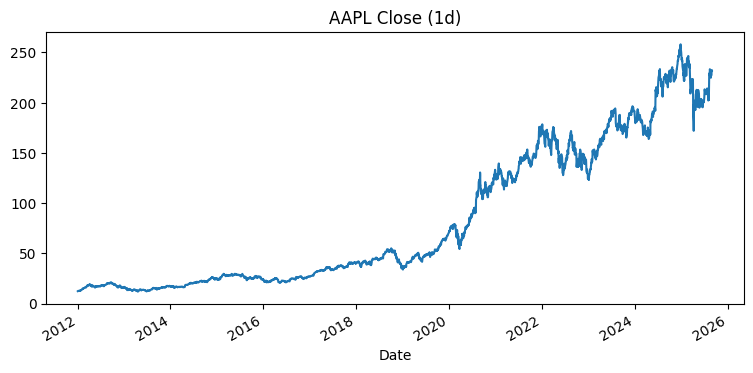

In [130]:
# --- Plot ---
df["close"].plot(title=f"{TICKER} Close ({INTERVAL})", figsize=(9,4))
plt.show()

In [131]:
# --- CSV einfrieren (mit den standardisierten Namen) ---
os.makedirs("../data", exist_ok=True)
csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
df.to_csv(csv_path)
print("CSV gespeichert unter:", csv_path)

CSV gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01.csv


In [132]:
csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
df = read_prices(csv_path)

In [133]:
exp = {"open","high","low","close","volume"}
assert exp.issubset(df.columns), f"Columns fehlen: {sorted(exp - set(df.columns))}"
assert not df.index.has_duplicates, "Duplicate timestamps"
assert (df["close"] > 0).all(), "Close muss positiv sein"
assert df.notna().all().all(), "NaNs im Frame"


In [134]:
# ---- 2) Hilfsfeature: 1-Tages-Logreturn (optional) ----
na_counts = df.isna().sum()
assert na_counts.sum() == 0, f"Remaining NaNs detected: {na_counts[na_counts > 0]}"

if (df["close"] <= 0).any():
    raise ValueError("Close prices must be positive for log-return computation")

df["logret_1d"] = np.log(df["close"]).diff()

# ---- 3) Zielvariable: Up/Down in HORIZON Schritten ----
future_log = np.log(df["close"]).shift(-HORIZON)
curr_log   = np.log(df["close"])
y_return   = future_log - curr_log
df["target"] = (y_return > 0).astype(int)


In [135]:
# Aufräumen (erste diff-Zeile & letzte HORIZON-Zeilen)
df_clean = df.dropna().copy()

In [136]:
# ---- 4) Checks ----
print("Spalten:", df_clean.columns.tolist())
print("Zeitraum:", df_clean.index.min().date(), "→", df_clean.index.max().date(), "| n =", len(df_clean))

print("\nVorschau:\n", df_clean[["close","logret_1d","target"]].head())

vc = df_clean["target"].value_counts().sort_index()
print("\nKlassenverteilung 0/1:", vc.to_dict(), "| Anteil 1:", round(vc.get(1,0)/vc.sum(), 3))

Spalten: ['open', 'high', 'low', 'close', 'volume', 'logret_1d', 'target']
Zeitraum: 2012-01-04 → 2025-08-29 | n = 3434

Vorschau:
                 close  logret_1d  target
Date                                    
2012-01-04  12.411520   0.005360       1
2012-01-05  12.549309   0.011041       1
2012-01-06  12.680497   0.010400       0
2012-01-09  12.660383  -0.001587       1
2012-01-10  12.705716   0.003574       0

Klassenverteilung 0/1: {0: 1622, 1: 1812} | Anteil 1: 0.528


In [137]:
# Mini-Horizon-Demo
i = df_clean.index[100]
j = df_clean.index[df_clean.index.get_loc(i) + HORIZON]
print(f"\nHorizon-Check: {i.date()} -> {j.date()}")
print("close_i =", df.loc[i, "close"], " | close_j =", df.loc[j, "close"])
print("target_i =", int(df_clean.loc[i, "target"]))


Horizon-Check: 2012-05-29 -> 2012-05-30
close_i = 17.17961311340332  | close_j = 17.386751174926758
target_i = 1


In [138]:
# ---- 5) Speichern für Block 3 ----
csv_out = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}.csv"
df_clean.to_csv(csv_out)
print("\nAufbereitete Datei gespeichert unter:", csv_out)


Aufbereitete Datei gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1.csv
